In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import string
import re
import nltk
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_text(url):
    response = requests.get(url)
    content = response.content
    parser = BeautifulSoup(content,'html.parser')
    return(parser.text)

In [3]:
def clean_text(script):
    script_clean=script.strip()
    script_clean=script_clean.replace("\n","")
    script_clean=script_clean.replace("\r"," ")
    script_clean=script_clean.replace("\r\n","")
    script_clean=re.sub("([\(\[]).*?([\)\]])", "", script_clean)
    script_clean=re.sub(r'\.([a-zA-Z])', r'. \1', script_clean) #remove missing whitespace between character lines.
    script_clean=re.sub(r'\!([a-zA-Z])', r'! \1', script_clean)
    script_clean=re.sub(r'\?([a-zA-Z])', r'? \1', script_clean)
    return(script_clean)

In [4]:
def get_cast(script_clean):
    tokens=nltk.word_tokenize(script_clean)
    cast=[]
    for word in tokens:
        if re.search("\\b[A-Z]{3,}\\b", word) is not None:
            cast.append(word)
    return(list(set(cast)))

In [5]:
script=get_text('http://www.chakoteya.net/DS9/575.htm')

In [6]:
script_clean=clean_text(script)

In [7]:
def get_lines(script_clean, cast):
    split_script=script_clean.split(':')
    lines_dict=dict.fromkeys(cast)
    for cast_member in cast:
        lines=[]
        for i in range(len(split_script)-1):
            if cast_member in split_script[i].strip().split(" "):
                line=split_script[i+1].strip().split(" ")
                line=[word for word in line if word != '']
                for member in cast:
                    if member in line:
                        line.remove(member)
                line=' '.join(line)
                lines.append(line)
        lines_dict[cast_member]=lines

    return(lines_dict)

In [8]:
def get_page_links():
    top_links=["http://www.chakoteya.net/DS9/episodes.htm", 
                   "http://www.chakoteya.net/StarTrek/episodes.htm", 
                   "http://www.chakoteya.net/NextGen/episodes.htm", 
                   "http://www.chakoteya.net/Voyager/episode_listing.htm", 
                   "http://www.chakoteya.net/Enterprise/episodes.htm"]
    short_links=["http://www.chakoteya.net/DS9/", 
                   "http://www.chakoteya.net/StarTrek/", 
                   "http://www.chakoteya.net/NextGen/", 
                   "http://www.chakoteya.net/Voyager/", 
                   "http://www.chakoteya.net/Enterprise/"]
    links_list=[]
    names_list=[]
    for i, link in enumerate(top_links):
        response = requests.get(link)
        content = response.content
        parser = BeautifulSoup(content,'html.parser')
        urls = parser.find_all('a')
        for page in urls:
            links_list.append(short_links[i]+str(page.get('href')))
            name=page.text
            name=name.replace('\r\n',' ')
            names_list.append(name)
            
    
    links_to_remove=['http://www.chakoteya.net/Voyager/fortyseven.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS1-S3.htm',
                     'http://www.chakoteya.net/Voyager/LineCountS4-S7.htm',
                     'http://www.chakoteya.net/Enterprise/fortyseven.htm',
                    ]
    links_list=[link for link in links_list if (link.endswith('.htm')) & (link not in links_to_remove)]
    
    return(links_list)

In [9]:
# links_list

In [10]:
page_links=get_page_links()

In [11]:
len(page_links)

708

In [12]:
DS9_links = page_links[0:173]
TOS_links = page_links[173:253]
TAS_links = page_links[253:275]
TNG_links = page_links[275:451]
VOY_links = page_links[451:611]
ENT_links = page_links[611:708]

links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

In [13]:
links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']
links=[DS9_links, TOS_links, TAS_links, TNG_links, VOY_links, ENT_links]

all_series_scripts={}
for i,series in enumerate(links):
    series_name=str(links_names[i])
    print(series_name)
    all_series_scripts[series_name]={}
    episode_script={}
    all_cast=[]
    for j,link in enumerate(series):
        episode="episode "+str(j)
        text=get_text(link)
        episode_script[episode]=text
    all_series_scripts[series_name]=episode_script

print(all_series_scripts)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
with open('all_scripts_raw.json', 'w') as data:
    json.dump(all_series_scripts, data)

In [15]:
with open('all_scripts_raw.json', 'r') as data:
    all_scripts_raw = json.load(data)

In [16]:

links_names=['DS9', 'TOS', 'TAS', 'TNG', 'VOY', 'ENT']

all_series_lines={}
for i,series in enumerate(links_names):
    print(series)
    series_name=str(links_names[i])
    all_series_lines[series_name]={}
    all_lines_dict={}
    all_cast=[]
    #for j,episode in enumerate(all_series_scripts[series]):
    for j,episode in enumerate(all_scripts_raw[series]):
        #script=all_series_scripts[series][episode]
        script=all_scripts_raw[series][episode]
        cleaned_script=clean_text(script)
        cast=get_cast(cleaned_script)
        for member in cast:
            if member not in all_cast:
                all_cast.append(member)
        lines_dict=get_lines(cleaned_script,all_cast)
        all_lines_dict[episode]=lines_dict
    all_series_lines[series]=all_lines_dict

print(all_series_lines)

DS9
TOS
TAS
TNG
VOY
ENT


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
with open('all_series_lines.json', 'w') as data:
    json.dump(all_series_lines, data)

In [18]:
with open('all_series_lines.json', 'r') as data:
    all_series_lines = json.load(data)

In [19]:
#checking against source to make sure the character lines
#appear in the correct episode
all_series_lines['TNG']['episode 30']['LAFORGE']

["He said something about his new image. I tell you, he's been acting kind of strange lately.",
 "Well, if I didn't know better, I'd say he was showing signs of insecurity.",
 "I don't know. Sometimes I think he's becoming more human than any of us realise.",
 'Data?',
 'Can we come in?',
 'Did you damage your face, Data?',
 'Yes, Captain.',
 "I'm on my way.",
 'Now remember, this is a near warp transport, so the effects may be a little unusual.',
 'Try and hold still, will you, Data?',
 "I wish I knew what to suggest. I'm damned if I can find a thing wrong with him.",
 'What, are you saying that Data is losing his mind?',
 "Well, sir, it's just a guess, but, sometimes he wants to be human so badly he can taste it. I think he just tends to get confused when his human qualities surface.",
 "Witnessing Graves' death may have been some sort of catalyst for the way he",
 'Data. Data, can you hear me?',
 'Yeah.',
 'I think you just did.',
 'You can ask me anything you want.']

In [20]:
#writing the corrected df
# all_series_lines = pd.DataFrame(data=all_series_lines)
# all_series_lines.to_csv(r'C:\Users\Eric\Desktop\Star_Trek_Scripts-master\Star_Trek_Scripts-master\data\all_series_lines.csv')
#when I wrote it to a df spock ended up getting lines???????????????

In [21]:
episodes=all_series_lines['TNG'].keys()

In [22]:
total_lines_counts={}
line_counts_by_episode={}
for i,ep in enumerate(episodes):
    if i == 0:
        episode="Episode 1 & 2"
    else:
        episode="Episode "+str(i+2)
    line_counts_by_episode[episode]={}
    if all_series_lines['TNG'][ep] is not np.NaN:
        for member in list(all_series_lines['TNG'][ep].keys()):
            line_counts_by_episode[episode][member]=len(all_series_lines['TNG'][ep][member])
            if member in total_lines_counts.keys():
                total_lines_counts[member]=total_lines_counts[member]+len(all_series_lines['TNG'][ep][member])
            else:
                total_lines_counts[member]=len(all_series_lines['TNG'][ep][member])

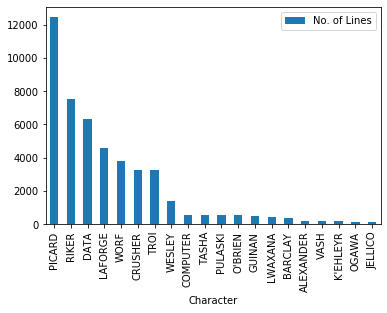

15        PICARD
12         RIKER
7           DATA
18       LAFORGE
17          WORF
1        CRUSHER
10          TROI
9         WESLEY
14      COMPUTER
21         TASHA
161      PULASKI
20       O'BRIEN
163       GUINAN
65       LWAXANA
335      BARCLAY
387    ALEXANDER
323         VASH
244     K'EHLEYR
263        OGAWA
615      JELLICO
Name: Character, dtype: object

In [23]:
#checking to make sure Spock doesn't appear, since that was an issue before
TNG_df_byep = pd.DataFrame(line_counts_by_episode)
# TNG_df_byep.loc['SPOCK']

TNG_df=pd.DataFrame(list(total_lines_counts.items()), columns=['Character','No. of Lines'])
Top20=TNG_df.sort_values(by='No. of Lines', ascending=False).head(20)

Top20.plot.bar(x='Character',y='No. of Lines')
plt.show()

Top20['Character']

In [24]:
export_TOP20 = Top20.to_csv(r'C:\Users\Eric\startrek-dash-app\assets\top20')

In [26]:
export_vis_TNG = TNG_df_byep.to_csv(r'C:\Users\Eric\startrek-dash-app\assets\bar_chart_TNG')